# Preliminary analysis

The data contains info about second hand cars. In the first part we develop a classifier to predict the class (low-end, mid, high-end) of the cars. In the second part we design a regression model to try to predict the exact price of the cars.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

%matplotlib inline

random_state=0

In [2]:
##To read directly from Drive in Google Colab use:
from google.colab import drive
drive.mount('/content/drive')
#input path: "./drive/MyDrive/CarPricesData.pkl"

##To read in Kaggle, upload file in Kaggle 
##input path: "/kaggle/input/botnetdl/botnet_dataset_DL.csv"

Mounted at /content/drive


In [121]:
df = pd.read_csv("./drive/MyDrive/DL/dataset.csv") #change path if needed



*   **Variables**



In [122]:
#Dataset size
df.shape[0]

1436

In [5]:
#Number of categorical and continuous variables
categorical_variables=['fuel_type','metcolor','automatic','doors_num']
continuous_variables=list(set(df.columns)-set(categorical_variables))
print('The categorical variables are: {}'.format(categorical_variables))
print('The continuous variables are: {}'.format(continuous_variables))
num_categorical_variables = len(categorical_variables)
num_continuous_variables = len(continuous_variables)

The categorical variables are: ['fuel_type', 'metcolor', 'automatic', 'doors_num']
The continuous variables are: ['price', 'weight', 'months_old', 'km', 'size_engine', 'horsepower']


In [123]:
#OneHotEncoding of the categorical variable 'fuel_type'
df_ohe = pd.get_dummies(df,columns=['fuel_type'])

*   **Distributions**





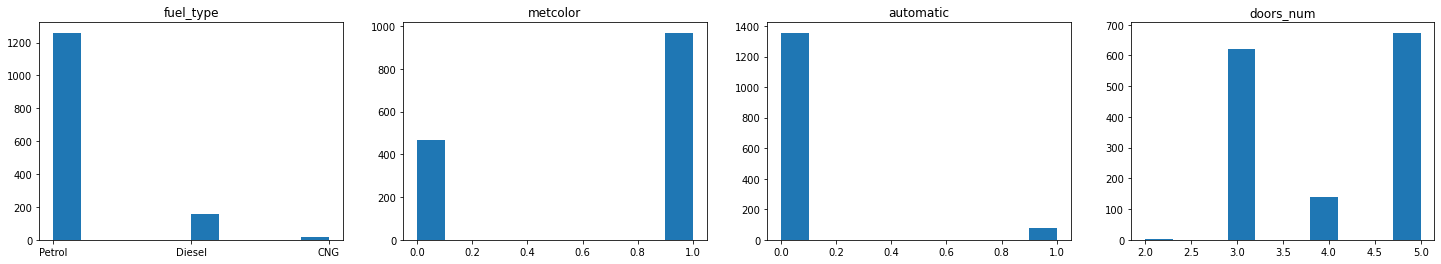

In [7]:
 #Distributions of categorical variables
fig, ax = plt.subplots(nrows=1, ncols=num_categorical_variables, figsize=(25,4))
for i in range(num_categorical_variables):
  ax[i].set_title(categorical_variables[i])
  ax[i].hist(df[categorical_variables[i]])

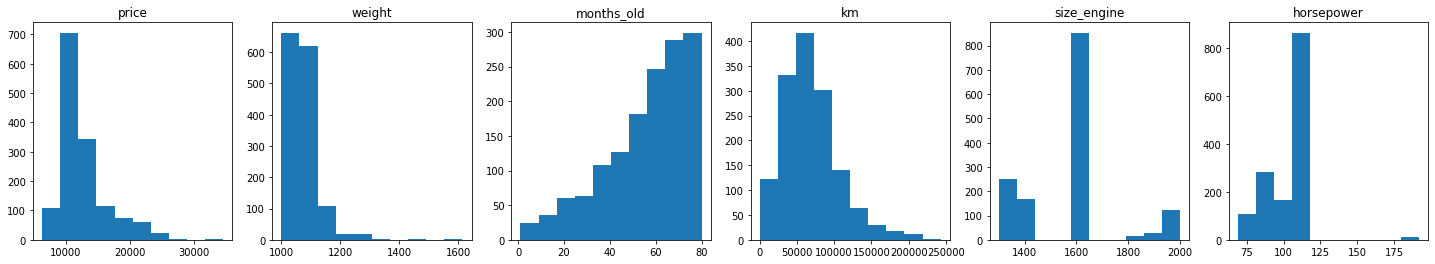

In [8]:
#Distributions continuous variables
fig, ax = plt.subplots(nrows=1, ncols=num_continuous_variables, figsize=(25,4))
for i in range(num_continuous_variables):
  ax[i].set_title(continuous_variables[i])
  ax[i].hist(df[continuous_variables[i]])

*   **Correlations**




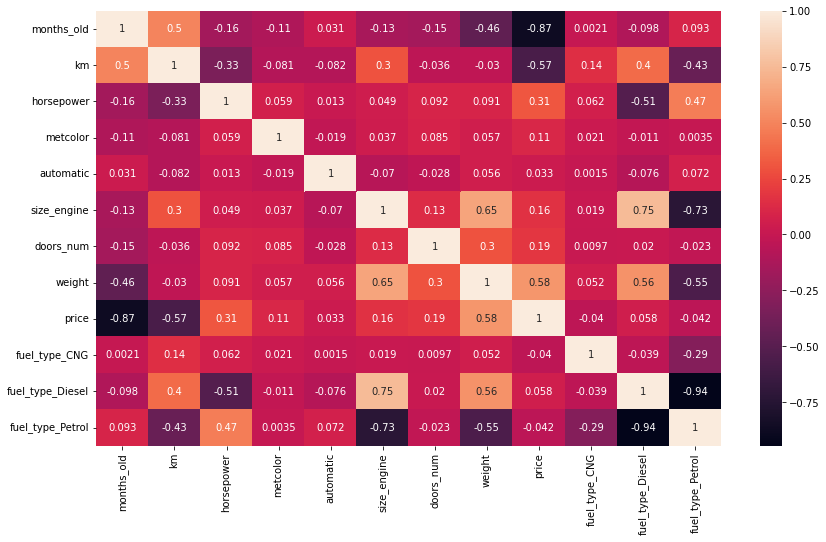

In [9]:
#All variables correlations
corr=df_ohe[df_ohe.columns].corr()
plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True)

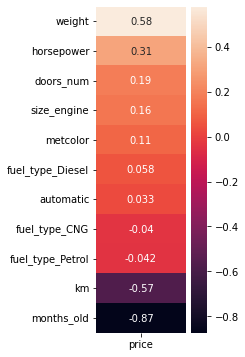

In [10]:
#Features correlating with Price
corr_price=df_ohe[df_ohe.columns].corr()['price'][:].sort_values(ascending=False).to_frame()
plt.figure(figsize=(2,6))
sns.heatmap(corr_price.drop('price'), annot=True)

** comments **

The features that have more positive correlation with the price of the car are 'weight' and 'horsepower', according to real world experience: a bigger (heavier) or a more powerful car usually cost more than a smaller and less powerful one.
On the other side the features that have more negative correlation are 'km' and 'months_old', always according to experience as they represent how much the car is worn-out.

## 2. Neural Network model: classification


En este apartado entrenaremos un modelo que intente clasificar los coches según su gama de precio. Para ello crearemos una nueva variable como indicador de calidad del coche (gama baja, media o alta), siguiendo las siguientes condiciones:



*   _low-end_: precio menor que 11000 euros
*   _medium-end_: precio mayor o igual que 11000 euros y menor que 13000
*   _high-end_: precio mayor o igual que 13000



We create a new variable that represents the price range of the cars:

*   _low-end_: price < 11000
*   _medium-end_: 13000 > price >= 11000
*   _high-end_: price >= 13000

### Pre-processing


In [11]:
#Create new variable: quality
def quality(price):
  if price<11000:
    return 'low-end'
  elif price>=13000:
    return 'high-end'
  else:
    return 'medium-end'

df_wq=df_ohe.assign(quality=df['price'].apply(quality))

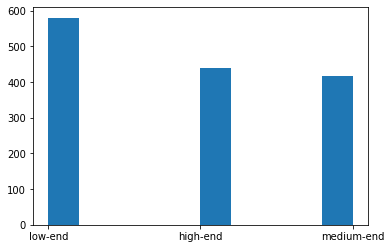

In [13]:
#Histogram car quality
plt.hist(df_wq['quality']);

In [14]:
#Create features and labels vectors
features = df_ohe.drop('price',axis=1)
labels = df_wq['quality']

In [15]:
#standadize the corresponding data 
#to normalize we could also use MinMaxScaler
ss=StandardScaler()
features_norm=ss.fit_transform(features)

In [16]:
#Binarize the labels
from sklearn.preprocessing import label_binarize, LabelBinarizer
lb = LabelBinarizer()
y_binarize = lb.fit_transform(labels)
#Y=label_binarize(labels, classes=['low-end','medium-end','high-end'])

In [17]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features_norm,y_binarize, test_size=0.2, stratify=y_binarize, random_state=random_state)
#the classes are not really too much unbalanced, but I've seen that using the stratify parameter the model accuracy on the validation set improves

In [18]:
#Shapes
print('The training set cointains {} instances with {} features.'.format(X_train.shape[0], X_train.shape[1]))
print('The test set cointains {} instances with {} features.'.format(X_test.shape[0], X_train.shape[1]))
print('Each instance has 1 of {} possible labels.'.format(y_train.shape[1]))

The training set cointains 1148 instances with 11 features.
The test set cointains 288 instances with 11 features.
Each instance has 1 of 3 possible labels.


### Base model


In [19]:
#Create ANN model
def new_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(64, input_shape=(11,), activation="relu"))
  model.add(keras.layers.Dense(32, activation="relu"))
  model.add(keras.layers.Dense(10, activation="relu"))
  model.add(keras.layers.Dense(8, activation="relu"))
  model.add(keras.layers.Dense(3, activation="softmax"))
  return model
model=new_model()

In [20]:
#Compile
model.compile(optimizer=Adam(learning_rate=0.1), loss="categorical_crossentropy", metrics=['accuracy'])

In [21]:
#Fit
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, verbose=0)

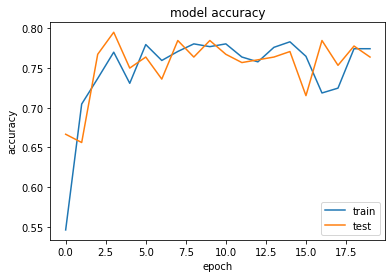

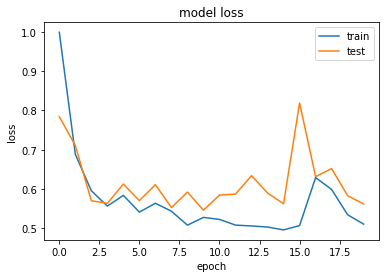

In [22]:
#Plots 
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Let's see the influence of the learning rate and optimizer

In [24]:
#I tried to use early stopping to do some experiments, I leave it here commented
#from tensorflow.keras.callbacks import EarlyStopping
#callback = EarlyStopping(monitor='loss', patience=3)

#Function to compute several models changing Optimizers and learning rate
def models(optimizers, learning_rates):
  histories=[]
  times=[]
  for optimizer in optimizers:
    for lr in learning_rates:
      model=new_model()
      model.compile(optimizer= optimizer (learning_rate=lr), loss="categorical_crossentropy", metrics=['accuracy'])
      t0 = timeit.default_timer()
      history=model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, verbose=0)#, callbacks=[callback])
      t1 = timeit.default_timer()
      times.append(t1-t0)
      histories.append(history)
  return histories,times

In [27]:
#Compute models
optimizers=[Adam, SGD, Adadelta, Adagrad]
learning_rates=[0.001, 0.01, 0.05, 0.1]
histories,times=models(optimizers=optimizers, learning_rates=learning_rates)

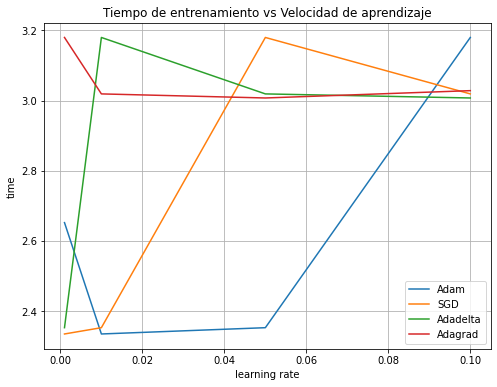

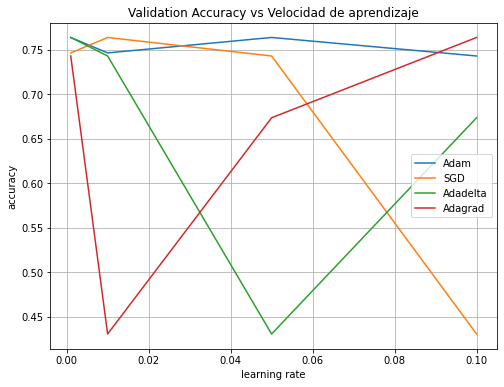

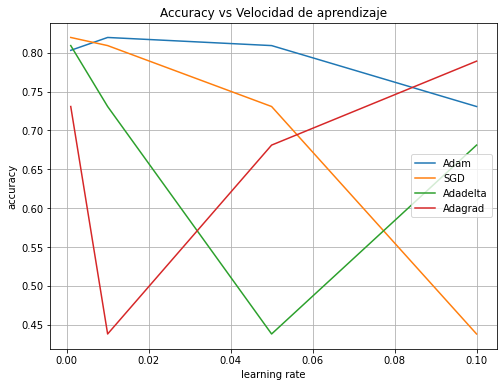

In [28]:
#Plots

plt.figure(figsize=(8,6))
for n,optimizer in enumerate(optimizers):
  plt.plot(learning_rates,times[n:n+4])
plt.title('Tiempo de entrenamiento vs Velocidad de aprendizaje')
plt.ylabel('time')
plt.xlabel('learning rate')
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'])
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
for n,optimizer in enumerate(optimizers):
  accuracy_list=[]
  for i in range(n,n+4):
    accuracy_list.append(histories[i].history['val_accuracy'][-1])
  plt.plot(learning_rates,accuracy_list)
plt.title('Validation Accuracy vs Velocidad de aprendizaje')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'])
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
for n,optimizer in enumerate(optimizers):
  accuracy_list=[]
  for i in range(n,n+4):
    accuracy_list.append(histories[i].history['accuracy'][-1])
  plt.plot(learning_rates,accuracy_list)
plt.title('Accuracy vs Velocidad de aprendizaje')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.legend(['Adam', 'SGD', 'Adadelta', 'Adagrad'])
plt.grid()
plt.show()

### Best model election

In [42]:
acc_values=[]
for h in histories:
  acc_values.append(h.history['val_accuracy'][-1])
print(acc_values)
print(np.argmax(np.array(acc_values)))

[0.7638888955116272, 0.7465277910232544, 0.7638888955116272, 0.7430555820465088, 0.4305555522441864, 0.6736111044883728, 0.7638888955116272, 0.7604166865348816, 0.3993055522441864, 0.4236111044883728, 0.4930555522441864, 0.7013888955116272, 0.4236111044883728, 0.7465277910232544, 0.7638888955116272, 0.7743055820465088]
15


The best accuracy on the validation set is obtained with the optimizer Adagrad and learning rate=0.1.

Adagrad scales the learning rate adapting to the slope of the path toward the optimum. The keras documentation says "Note that Adagrad tends to benefit from higher initial learning rate values compared to other optimizers". Anyway, the book 'Hands on Machine Learing with Scikit-Learn, Keras & TensorFlow' by A.Géron tells us to be careful using Adagrad because "The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum". This makes me think that is possible that the best performance obtained by Adagrad is caused by the fact that we only considered 20 epochs for the traing. 
I did some experiments to test this hypotesis and I've seen that sometimes Adadelta or Adam seem to surpass slightly the performance of Adagrad when the number of epochs increases, using Early Stopping to avoid overfitting. But Adagrad seems to remain the best performing optimizer overall, so I choose it as the best model.

Some comments about the training time:

The fastest trainings are obtained using Adam with learning rate=0.01 and SGD with learning rate=0.001.
If I had time concerns maybe I could have adopted the optimizers Adam or SGD for training, but trying to maximize accuracy I choose Adagrad.


In [44]:
#Create, compile and fit ANN BEST model
best=new_model()
best.compile(optimizer= Adagrad (learning_rate=0.1), loss="categorical_crossentropy", metrics=['accuracy'])
history=best.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, verbose=0)

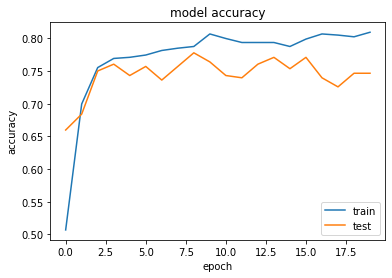

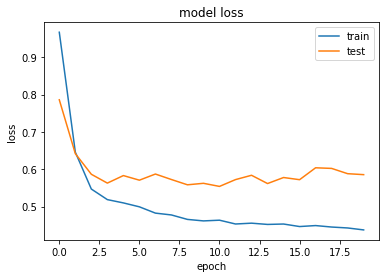

In [45]:
#Plots
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

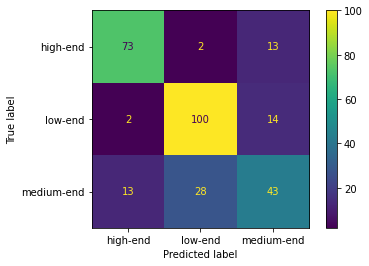

In [65]:
#Confusion matrix
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix

y_test_original = lb.inverse_transform(y_test)
y_pred = best.predict(X_test)
quality_predicted=np.where(y_pred > 0.5, 1,0)
quality_pred_original = lb.inverse_transform(quality_predicted)
cm=confusion_matrix(y_test_original, quality_pred_original);
ConfusionMatrixDisplay.from_predictions(y_test_original, quality_pred_original);

In [67]:
#Accuracy
correct=sum(np.diagonal(cm))
total=y_test.shape[0] #can be computed using: sum(sum(cm))
Accuracy=correct/total
print('The accuracy of the model on the validation set is {}'.format(Accuracy))

The accuracy of the model on the validation set is 0.75


In [82]:
#Precision, Recall and F1-score for each label

#high_end
TP_h=cm[0,0]
FP_h=sum(cm[1:,0])
FN_h=sum(cm[0,1:])
high_precision=TP_h/(TP_h+FP_h)
high_recall=TP_h/(FN_h+TP_h)
high_F1=2*high_precision*high_recall/(high_precision+high_recall)
print('For the label "high-end" the Precision is {:0.2f}, the Recall is {:0.2f}, and the F1-score is {:0.2f} '.format(
    high_precision,high_recall,high_F1))

TP_m=cm[2,2]
FP_m=sum(cm[:2,2])
FN_m=sum(cm[2,:2])
m_precision=TP_m/(TP_m+FP_m)
m_recall=TP_m/(FN_m+TP_m)
m_F1=2*m_precision*m_recall/(m_precision+m_recall)
print('For the label "medium-end" the Precision is {:0.2f}, the Recall is {:0.2f}, and the F1-score is {:0.2f} '.format(
    m_precision,m_recall,m_F1))

TP_l=cm[1,1]
FP_l=cm[0,1]+cm[2,1]
FN_l=cm[1,0]+cm[1,2]
l_precision=TP_l/(TP_l+FP_l)
l_recall=TP_h/(FN_l+TP_l)
l_F1=2*l_precision*l_recall/(l_precision+l_recall)
print('For the label "low-end" the Precision is {:0.2f}, the Recall is {:0.2f}, and the F1-score is {:0.2f} '.format(
    l_precision,l_recall,l_F1))



For the label "high-end" the Precision is 0.83, the Recall is 0.83, and the F1-score is 0.83 
For the label "medium-end" the Precision is 0.61, the Recall is 0.51, and the F1-score is 0.56 
For the label "low-end" the Precision is 0.77, the Recall is 0.63, and the F1-score is 0.69 


In [ ]:
#Comment results

The model has some problems predicting values in the mid-end. It was even worse, then I tried to use the parameter stratify in train_test_split to adjust to the fact that the medium-end cars are slightly underrepresented in the data and this increased a little the performance.

## 3. Regression model

### Pre-processing




In [85]:
#Create features and target vectors
features = df_ohe.drop('price',axis=1).values
target = df_ohe['price'].values

In [87]:
#Normalizing the data
ssf=StandardScaler()
features_norm=ssf.fit_transform(features)
sst=MinMaxScaler() #we need values in the 0-1 range since we will use the sigmoid function for the output layer
target_norm=sst.fit_transform(target.reshape(-1, 1))

In [88]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(features_norm,target_norm, test_size=0.3, random_state=random_state)

In [89]:
#Dimensions
print('The training set cointains {} instances with {} features.'.format(X_train.shape[0], X_train.shape[1]))
print('The test set cointains {} instances with {} features.'.format(X_test.shape[0], X_train.shape[1]))

The training set cointains 1005 instances with 11 features.
The test set cointains 431 instances with 11 features.


### Base model

In [90]:
#Create ANN model
def regression_model(layers_dims):
    L = len(layers_dims)
    model = Sequential()
    model.add(Dense(layers_dims[1], input_shape=(layers_dims[0],), activation="relu", kernel_initializer="normal"))
    for l in range(2, L-1):
        model.add(Dense(layers_dims[l], activation="tanh", kernel_initializer="normal"))
    
    model.add(Dense(layers_dims[L-1], activation="sigmoid", kernel_initializer="normal"))
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
    return model

In [91]:
#Compiling the model
layers_dims=[11,128,32,16,1]
r_model=regression_model(layers_dims)

In [92]:
#Fit model
history=r_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, verbose=0)

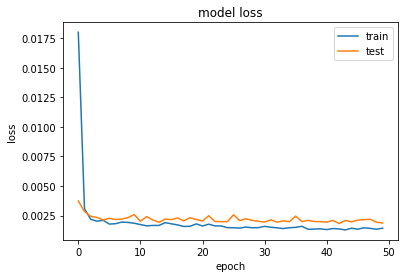

In [93]:
#Plots
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Hiperparameters optimization

In [96]:
#Hiperparameter search function
from math import sqrt
layers_dims_list=[[11,128,64,16,1], [11,16,4,1], [11,4,4,1]]
batch_size_list=[16,32]
epochs_list=[20,50,100]

def hyperparameters_table(layers_dims_list, batch_size_list, epochs_list):
  data = {'Architecture': [], 'epochs': [], 'batch size': [] , 'training time': [],
           'RMSE' : [], 'RMSE_val': []} 
           #I add the RMSE on the training set because it may be a useful information to see how the training is going
  for layers_dims in layers_dims_list:
    for epochs in epochs_list:
      for batch_size in batch_size_list:
        model=regression_model(layers_dims)
        t1=timeit.default_timer()
        history=model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch_size, verbose=0)
        t2=timeit.default_timer()
        time=t2-t1
        data['Architecture'].append(layers_dims)
        data['epochs'].append(epochs)
        data['batch size'].append(batch_size)
        data['training time'].append(time)
        data['RMSE'].append(sqrt(history.history['loss'][-1]))
        data['RMSE_val'].append(sqrt(history.history['val_loss'][-1]))
  table=pd.DataFrame(data)
  return table
  

In [97]:
#Compute search
table=hyperparameters_table(layers_dims_list, batch_size_list, epochs_list)
table

,Architecture,epochs,batch size,training time,RMSE,RMSE_val
0,"[11, 128, 64, 16, 1]",20,16,4.665742,0.044615,0.050601
1,"[11, 128, 64, 16, 1]",20,32,2.820937,0.040104,0.046837
2,"[11, 128, 64, 16, 1]",50,16,10.745821,0.041498,0.049205
3,"[11, 128, 64, 16, 1]",50,32,10.735516,0.035147,0.043147
4,"[11, 128, 64, 16, 1]",100,16,20.907527,0.035646,0.047814
5,"[11, 128, 64, 16, 1]",100,32,12.580756,0.035069,0.046029
6,"[11, 16, 4, 1]",20,16,6.135232,0.041073,0.048200
7,"[11, 16, 4, 1]",20,32,4.257233,0.039769,0.049217
8,"[11, 16, 4, 1]",50,16,21.076019,0.037868,0.051305
9,"[11, 16, 4, 1]",50,32,6.244208,0.036507,0.046577


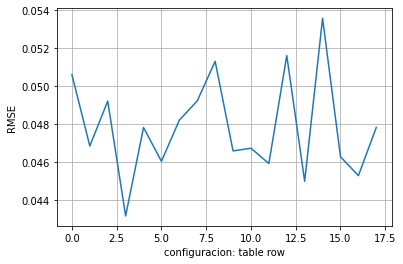

In [98]:
#Plot
#plt.plot(table['RMSE'])
plt.plot(table['RMSE_val'])
plt.grid()
plt.xlabel('configuracion: table row')
plt.ylabel('RMSE')
#plt.legend(['RMSE', 'RMSE_val'], loc='lower right')
plt.show()

In [ ]:
#Best configuration justification

From the plot we can see that the configuration that has the smaller RMSE is the 3rd:

layers: [11, 128, 64, 16, 1]	

number of epochs: 50	

batch size: 32

In [99]:
#Create, compile and fit ANN best model
best_row=3
model=regression_model(table['Architecture'][best_row])
history=model.fit(X_train, y_train, epochs=table['epochs'][best_row], validation_data=(X_test, y_test), batch_size=table['batch size'][best_row], verbose=0)

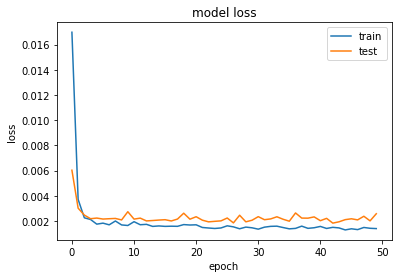

In [100]:
#Plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [103]:
#Generate Predictions on testing data
predicted_price=model.predict(X_test)
predicted_price_original=sst.inverse_transform(predicted_price).flatten()
y_test_original=sst.inverse_transform(y_test).flatten()
#y_test_original=y_test_original.flatten()
data={'price': y_test_original, 'predicted price': predicted_price_original}
df=pd.DataFrame(data)
df[:10]

,price,predicted price
0,9250.0,10157.780273
1,10750.0,10271.795898
2,12750.0,12968.036133
3,9450.0,9439.255859
4,16750.0,12994.333984
5,15250.0,14771.378906
6,12500.0,12346.152344
7,16950.0,12543.516602
8,9600.0,10351.900391
9,9950.0,10989.568359


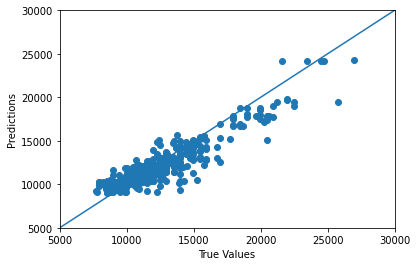

In [113]:
#some plots to better visualize the predicted data and error

plt.scatter(y_test_original, predicted_price_original)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [5000, 30000]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims);

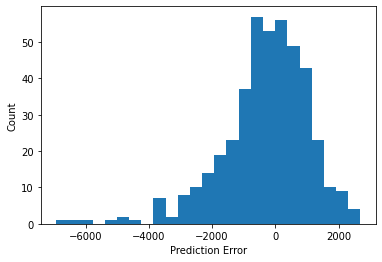

In [114]:
error = predicted_price_original - y_test_original
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count');

In [119]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, predicted_price_original)
print("Model R2: {:0.2f}".format(r2))

Model R2: 0.83


In [ ]:
#Comment results

The regression model performs discretely, with an R2 score of 0.83. 

From the histogram of the errors we can see that the errors are quite well normally distributed near 0. We can also see that the model tends to badly underestimate the price of some cars, this is not necessarly an error of our model, it may also be the case that those cars were sold for a price too high for their real value.